# **Projet - Network Analysis**

## Requirements

In [1]:
import pandas as pd
import pickle
import os
import numpy as np
import glob as gb
import networkx as nx
from transformers import BertTokenizer, BertModel
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Chargement de la base de données

In [3]:
# Chemin vers fichier CSV échantillonné
chemin_fichier = '/content/drive/MyDrive/database/data_sampled.csv'

# Charger le fichier CSV dans un DataFrame Pandas
data = pd.read_csv(chemin_fichier)

# Afficher les premières lignes du DataFrame pour vérifier
print(data.head())

   Unnamed: 0                                        identifiant  \
0      283486  https://www.persee.fr/doc/coloc_2111-8779_2014...   
1      314354  https://www.persee.fr/doc/dha_0755-7256_2004_n...   
2      344869  https://www.persee.fr/doc/ecoru_0013-0559_1998...   
3      353559  https://www.persee.fr/doc/ephe_0000-0001_1933_...   
4      229063  https://www.persee.fr/doc/bulmo_0007-473x_1922...   

                                               titre  \
0  Présentation - Le prix de thèse 2013 des colle...   
1  Antiquité et franquisme : Antigüedad y franqui...   
2  Implantations et agrandissements de grandes su...   
3                  Épigraphie et antiquités romaines   
4  Le château de Blois. Notice historique et arch...   

                                         abstract_fr  Date_publication  \
0                                                NaN              2014   
1                                                NaN              2004   
2   Durant les années 1980, le t

## Fonction 1 - Acquisition des données

In [4]:
# Statistiques descriptives pour les colonnes numériques
statistics = data.describe()

# Affichage des statistiques
print("Statistiques descriptives pour les colonnes numériques :\n", statistics)

# Comptage des valeurs uniques dans chaque colonne
unique_counts = data.nunique()

# Affichage du nombre de valeurs uniques par colonne
print("\nNombre de valeurs uniques par colonne :\n", unique_counts)

# Comptage des valeurs manquantes par colonne
missing_values = data.isnull().sum()

# Affichage du nombre de valeurs manquantes par colonne
print("\nNombre de valeurs manquantes par colonne :\n", missing_values)

Statistiques descriptives pour les colonnes numériques :
           Unnamed: 0  Date_publication
count  272634.000000     272634.000000
mean   454665.227639       1964.538473
std    262325.467402         39.063600
min         0.000000       1821.000000
25%    227193.250000       1943.000000
50%    454933.500000       1977.000000
75%    681686.500000       1994.000000
max    908777.000000       2020.000000

Nombre de valeurs uniques par colonne :
 Unnamed: 0          272634
identifiant         272634
titre               229796
abstract_fr          30402
Date_publication       190
auteur_0             61988
auteur_1             12823
auteur_2              4628
auteur_3              2049
auteur_4              1049
auteur_5               615
auteur_6               371
auteur_7               264
auteur_8               187
auteur_9               142
cite_par_0           13499
cite_par_1            5653
cite_par_2            2803
cite_par_3            1532
cite_par_4             883
cite_par_

In [5]:
# Initialiser un dictionnaire pour stocker les statistiques pour chaque auteur
stats_par_auteur = {}

# Liste des colonnes d'auteurs
colonnes_auteurs = ['auteur_0', 'auteur_1', 'auteur_2', 'auteur_3', 'auteur_4',
                    'auteur_5', 'auteur_6', 'auteur_7', 'auteur_8', 'auteur_9']

# Calcul des statistiques pour chaque auteur
for colonne in colonnes_auteurs:
    # Nombre de documents par auteur (en ne tenant pas compte des valeurs nulles)
    nombre_documents_par_auteur = data[colonne].dropna().count()

    # Ajouter les statistiques dans le dictionnaire
    stats_par_auteur[colonne] = {
        'nombre_documents': nombre_documents_par_auteur,
        'nombre_documents_total': len(data),
        'pourcentage_documents': (nombre_documents_par_auteur / len(data)) * 100
    }

# Afficher les statistiques pour chaque auteur
for auteur, stats in stats_par_auteur.items():
    print(f"\nStatistiques pour l'auteur {auteur} :\n")
    print("Nombre de documents :", stats['nombre_documents'])
    print("Nombre de documents total :", stats['nombre_documents_total'])
    print("Pourcentage de documents :", stats['pourcentage_documents'], "%")


Statistiques pour l'auteur auteur_0 :

Nombre de documents : 217018
Nombre de documents total : 272634
Pourcentage de documents : 79.60049003425839 %

Statistiques pour l'auteur auteur_1 :

Nombre de documents : 22315
Nombre de documents total : 272634
Pourcentage de documents : 8.184965925013021 %

Statistiques pour l'auteur auteur_2 :

Nombre de documents : 9926
Nombre de documents total : 272634
Pourcentage de documents : 3.640778479573347 %

Statistiques pour l'auteur auteur_3 :

Nombre de documents : 5709
Nombre de documents total : 272634
Pourcentage de documents : 2.0940161535245054 %

Statistiques pour l'auteur auteur_4 :

Nombre de documents : 3812
Nombre de documents total : 272634
Pourcentage de documents : 1.3982115216737458 %

Statistiques pour l'auteur auteur_5 :

Nombre de documents : 2920
Nombre de documents total : 272634
Pourcentage de documents : 1.0710329599389659 %

Statistiques pour l'auteur auteur_6 :

Nombre de documents : 2308
Nombre de documents total : 27263

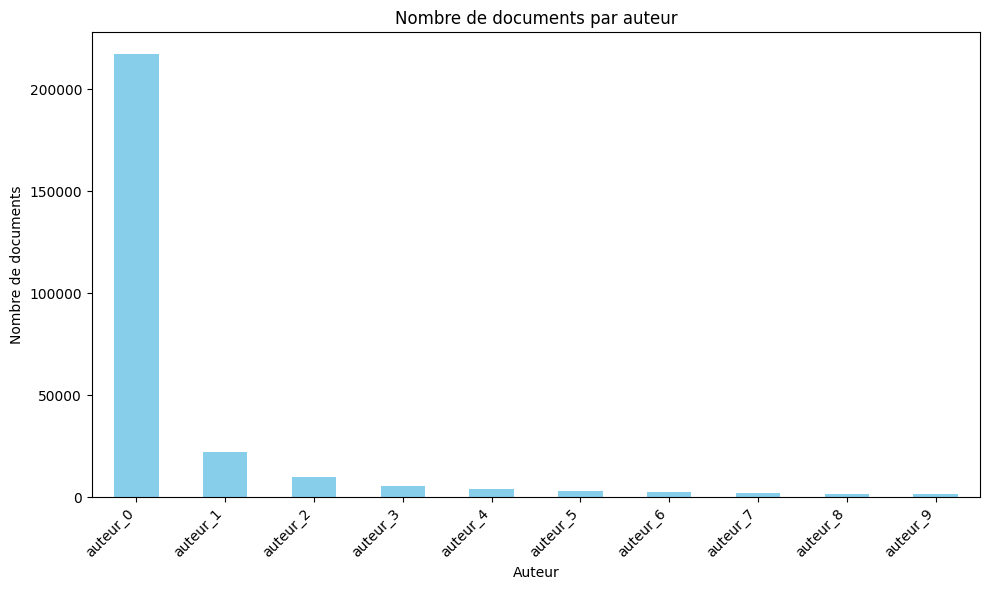

In [6]:
import matplotlib.pyplot as plt

# Convertir le dictionnaire stats_par_auteur en DataFrame pour faciliter la manipulation des données
stats_df = pd.DataFrame.from_dict(stats_par_auteur, orient='index')

# Trier les données par nombre de documents
stats_df = stats_df.sort_values(by='nombre_documents', ascending=False)

# Afficher les statistiques sous forme de graphique à barres
plt.figure(figsize=(10, 6))
stats_df['nombre_documents'].plot(kind='bar', color='skyblue')
plt.title('Nombre de documents par auteur')
plt.xlabel('Auteur')
plt.ylabel('Nombre de documents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

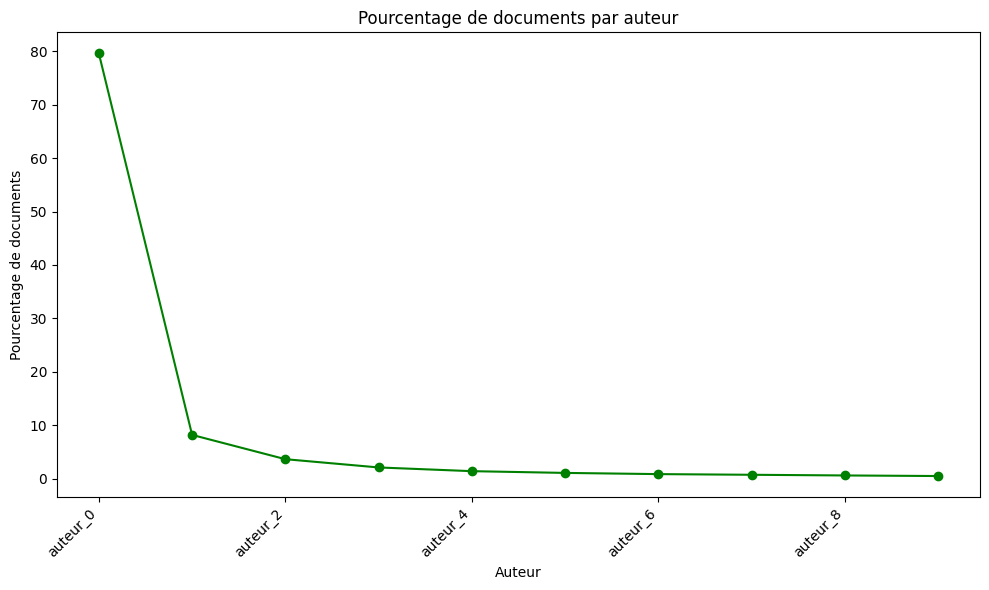

In [7]:
# Afficher les statistiques sous forme de tracé
plt.figure(figsize=(10, 6))
stats_df['pourcentage_documents'].plot(kind='line', marker='o', color='green')
plt.title('Pourcentage de documents par auteur')
plt.xlabel('Auteur')
plt.ylabel('Pourcentage de documents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [8]:
# Initialiser un dictionnaire pour stocker les statistiques pour chaque Date de publication
stats_par_date_publication = {}

# Calcul des statistiques pour chaque Date de publication
for date in data['Date_publication'].unique():
    # Nombre de documents par Date de publication (en ne tenant pas compte des valeurs nulles)
    nombre_documents_par_date = data[data['Date_publication'] == date].shape[0]

    # Ajouter les statistiques dans le dictionnaire
    stats_par_date_publication[date] = {
        'nombre_documents': nombre_documents_par_date,
        'nombre_documents_total': len(data),
        'pourcentage_documents': (nombre_documents_par_date / len(data)) * 100
    }

# Afficher les statistiques pour chaque Date de publication
for date, stats in stats_par_date_publication.items():
    print(f"\nStatistiques pour la date de publication {date} :\n")
    print("Nombre de documents :", stats['nombre_documents'])
    print("Nombre de documents total :", stats['nombre_documents_total'])
    print("Pourcentage de documents :", stats['pourcentage_documents'], "%")


Statistiques pour la date de publication 2014 :

Nombre de documents : 1348
Nombre de documents total : 272634
Pourcentage de documents : 0.4944357636978513 %

Statistiques pour la date de publication 2004 :

Nombre de documents : 3276
Nombre de documents total : 272634
Pourcentage de documents : 1.2016109509452233 %

Statistiques pour la date de publication 1998 :

Nombre de documents : 4735
Nombre de documents total : 272634
Pourcentage de documents : 1.736760638805138 %

Statistiques pour la date de publication 1933 :

Nombre de documents : 1185
Nombre de documents total : 272634
Pourcentage de documents : 0.43464864983824464 %

Statistiques pour la date de publication 1922 :

Nombre de documents : 1136
Nombre de documents total : 272634
Pourcentage de documents : 0.4166758364694058 %

Statistiques pour la date de publication 1979 :

Nombre de documents : 3145
Nombre de documents total : 272634
Pourcentage de documents : 1.153561184591797 %

Statistiques pour la date de publication

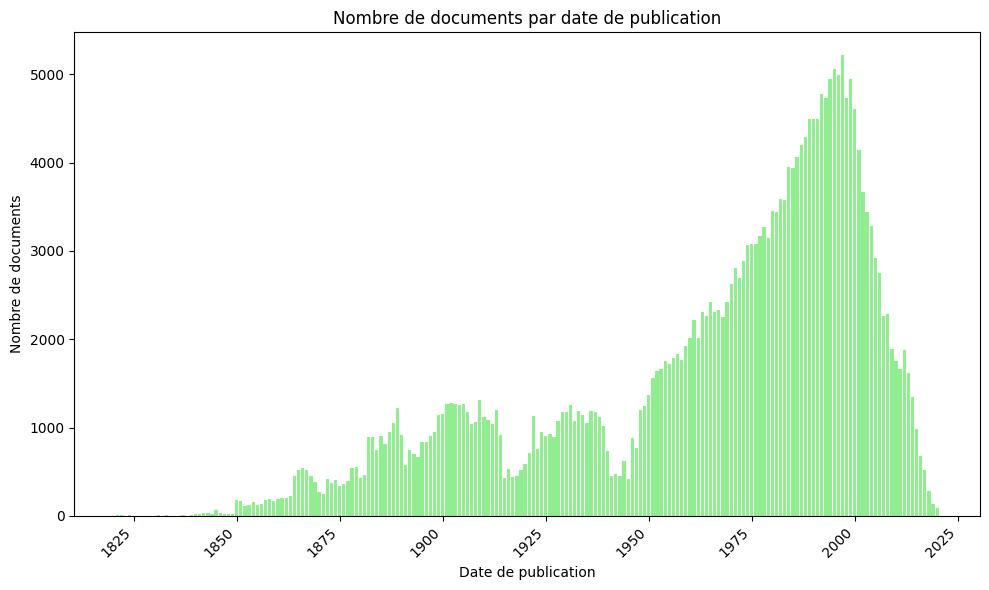

In [9]:
# Diagramme à barres pour le nombre de documents par date de publication
dates = list(stats_par_date_publication.keys())
nombre_documents = [stats['nombre_documents'] for stats in stats_par_date_publication.values()]

plt.figure(figsize=(10, 6))
plt.bar(dates, nombre_documents, color='lightgreen')
plt.xlabel('Date de publication')
plt.ylabel('Nombre de documents')
plt.title('Nombre de documents par date de publication')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [10]:
# Initialiser un dictionnaire pour stocker les statistiques pour chaque Date de publication
auteurs_par_date_publication = {}

# Calcul des statistiques pour chaque Date de publication
for date in data['Date_publication'].unique():
    # Sélectionner les données correspondant à la Date de publication actuelle
    data_date = data[data['Date_publication'] == date]

    # Initialiser un ensemble pour stocker les auteurs uniques
    auteurs_uniques = set()

    # Parcourir les colonnes d'auteurs et ajouter les auteurs uniques à l'ensemble
    for colonne_auteur in colonnes_auteurs:
        auteurs_uniques.update(data_date[colonne_auteur].dropna().unique())

    # Nombre d'auteurs par Date de publication
    nombre_auteurs_par_date = len(auteurs_uniques)

    # Ajouter les statistiques dans le dictionnaire
    auteurs_par_date_publication[date] = {
        'nombre_auteurs': nombre_auteurs_par_date
    }

# Afficher les statistiques pour chaque Date de publication
for date, stats in auteurs_par_date_publication.items():
    print(f"\nNombre d'auteurs pour la date de publication {date} :", stats['nombre_auteurs'])


Nombre d'auteurs pour la date de publication 2014 : 1291

Nombre d'auteurs pour la date de publication 2004 : 2652

Nombre d'auteurs pour la date de publication 1998 : 3782

Nombre d'auteurs pour la date de publication 1933 : 584

Nombre d'auteurs pour la date de publication 1922 : 440

Nombre d'auteurs pour la date de publication 1979 : 2274

Nombre d'auteurs pour la date de publication 1878 : 135

Nombre d'auteurs pour la date de publication 1993 : 3445

Nombre d'auteurs pour la date de publication 2005 : 2477

Nombre d'auteurs pour la date de publication 1951 : 804

Nombre d'auteurs pour la date de publication 2002 : 3042

Nombre d'auteurs pour la date de publication 1988 : 3100

Nombre d'auteurs pour la date de publication 1996 : 3883

Nombre d'auteurs pour la date de publication 1990 : 3206

Nombre d'auteurs pour la date de publication 1942 : 266

Nombre d'auteurs pour la date de publication 1917 : 210

Nombre d'auteurs pour la date de publication 1903 : 438

Nombre d'auteurs pou

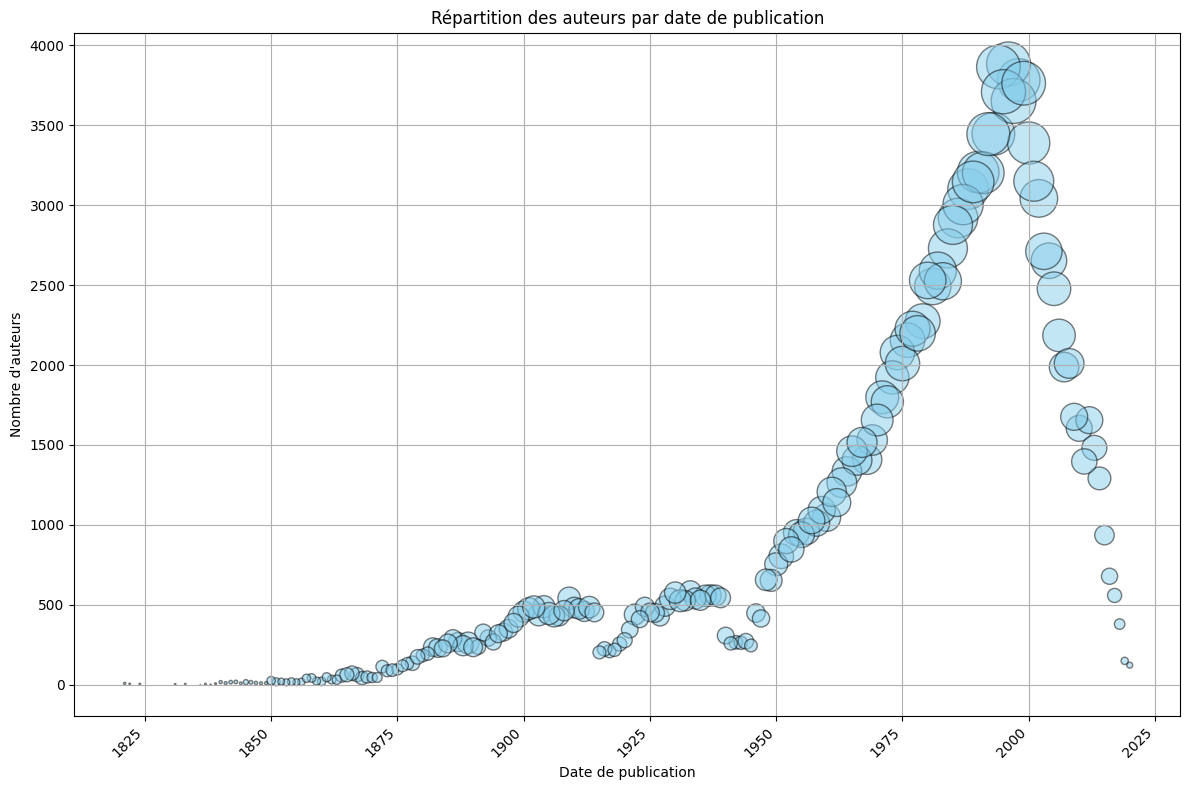

In [11]:
import matplotlib.pyplot as plt

# Récupérer les données pour le graphique à bulles
dates = list(auteurs_par_date_publication.keys())
nombre_auteurs = [stats['nombre_auteurs'] for stats in auteurs_par_date_publication.values()]
nombre_documents = [stats_par_date_publication[date]['nombre_documents'] for date in dates]

# Calculer la taille des bulles en fonction du nombre de documents
taille_bulles = [doc * 0.2 for doc in nombre_documents]  # Multiplier par 10 pour rendre les bulles plus visibles

# Créer le graphique à bulles
plt.figure(figsize=(12, 8))
plt.scatter(dates, nombre_auteurs, s=taille_bulles, alpha=0.5, c='skyblue', edgecolors='black')

# Ajouter des étiquettes et un titre
plt.xlabel('Date de publication')
plt.ylabel('Nombre d\'auteurs')
plt.title('Répartition des auteurs par date de publication')

# Afficher le graphique
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

## Fonction 2 - Prise en compte de la structure du corpus

In [12]:
# Liste des chemins des fichiers pickle
# On utilise une partie des fichiers par soucis d'executablitité !!
chemins = [
    "/content/drive/MyDrive/20240125_dataset_pickle/20240124_dataset_1895_assr.pickle",
    "/content/drive/MyDrive/20240125_dataset_pickle/20240125_dataset_autog_cemot.pickle",
    "/content/drive/MyDrive/20240125_dataset_pickle/20240125_dataset_cep_efr.pickle"
    #"/content/drive/MyDrive/20240125_dataset_pickle/20240125_dataset_emixx_grif.pickle"
    #"/content/drive/MyDrive/20240125_dataset_pickle/20240125_dataset_hedu_karst.pickle"
    #"/content/drive/MyDrive/20240125_dataset_pickle/20240125_dataset_ktema_numi.pickle",
    #"/content/drive/MyDrive/20240125_dataset_pickle/20240125_dataset_ofce_receo.pickle",
    #"/content/drive/MyDrive/20240125_dataset_pickle/20240125_dataset_recod_rqdi.pickle",
    #"/content/drive/MyDrive/20240125_dataset_pickle/20240125_dataset_rscir_xxs.pickle"
]

# Lecture des 100 premières lignes de chaque fichier et concaténation
dataframes = []
for chemin in chemins:
    df = pd.read_pickle(chemin).iloc[:300]
    dataframes.append(df)

concatenated_df = pd.concat(dataframes)

# Extraction de l'ID du domaine
y = [st[len("http://data.persee.fr/doc/"):st.find("_")] for st in concatenated_df.index]

# Chargement des données de discipline à partir du fichier CSV
domaines = pd.read_csv("/content/drive/MyDrive/20240141_disciplines.csv", sep=";")

# Traduction au domaine
y_domaine = [domaines[domaines.collection_id == yy].Discipline.values[0] for yy in y]

# Affichage des 5 premières lignes pour vérification
print(concatenated_df.head())

                                                   persee:dateOfPrintPublication{Literal}(xsd:gYear)  \
http://data.persee.fr/doc/1895_0769-0959_1986_n...                                              1986   
http://data.persee.fr/doc/1895_0769-0959_1986_n...                                              1986   
http://data.persee.fr/doc/1895_0769-0959_1986_n...                                              1986   
http://data.persee.fr/doc/1895_0769-0959_1986_n...                                              1986   
http://data.persee.fr/doc/1895_0769-0959_1986_n...                                              1986   

                                                                           marcrel:aut{URIRef}[0]  \
http://data.persee.fr/doc/1895_0769-0959_1986_n...                                            NaN   
http://data.persee.fr/doc/1895_0769-0959_1986_n...                                            NaN   
http://data.persee.fr/doc/1895_0769-0959_1986_n...                      

In [13]:
np.unique(y_domaine)

array(['Histoire', 'Science politique', 'Sociologie'], dtype='<U17')

In [14]:
sequences = concatenated_df['dcterms:title{Literal}'].values
sequences

array(['La cinémathèque rose ', 'Vis «Comica» ', 'La bande à Léon ',
       'The Perret touch ', 'Les débuts du cinéma à Angoulême ',
       'Ouvertures',
       'Extraits de Le Rire : Essai sur la signification du comique',
       "D'Anatole à Zoé ",
       'Gabriel-Maximilien Leuvielle et Charles Petit-Demange ',
       'Les douze travaux de Boireau ', 'Éclairs et éclipses ',
       "Revue d'histoire moderne et contemporaine, tome XXXIII, avril-juin 1986",
       "Paolo Cherchi Usai, Giovanni Pastrone. Gli anni d'oro del cinema a Torino, 1986",
       'La Saison Lumière à Montpellier, 22 avril - 29 novembre 1896 ',
       'Ouvertures',
       'Les bandes cinématographiques en couleurs artificielles. Un exemple : les films de Georges Méliès coloriés à la main ',
       'Clouzot inconnu ', 'Pordenone 1986 ',
       'La production Gaumont éditée au début du siècle en cartes postales ',
       'La page des chercheurs',
       'Schiave blanche allo specchio. Le origine del cinema in Scand

In [15]:
# Chargement du tokenizer et du modèle pré-entraîné BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [16]:
# Encodage des séquences
encoded_sequences = []
for seq in sequences:
    # Tokenisation
    tokens = tokenizer.tokenize(seq)
    # Ajout des tokens [CLS] et [SEP]
    tokens = ['[CLS]'] + tokens + ['[SEP]']
    # Convertir les tokens en identifiants d'index
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    # Convertir en tenseur pyTorch
    input_ids = torch.tensor(input_ids).unsqueeze(0)  # unsqueeze(0) pour ajouter une dimension de batch

    # Passer les données par le modèle BERT
    with torch.no_grad():
        outputs = model(input_ids)

    # Obtenir les embeddings de la couche cachée
    hidden_states = outputs[0]  # récupérer les embeddings de la couche cachée
    # Prendre la sortie de la première position ([CLS]) pour résumer la séquence
    cls_embedding = hidden_states[:, 0, :]  # [batch_size, 1, hidden_size] -> [batch_size, hidden_size]

    # Ajouter l'embedding de la séquence encodée à la liste
    encoded_sequences.append(cls_embedding)

In [17]:
# Concaténer les embeddings en un seul tensor
encoded_sequences = torch.cat(encoded_sequences, dim=0)
encoded_sequences

tensor([[-0.6548,  0.1670, -0.0306,  ..., -0.3326,  0.3338,  0.5325],
        [-0.5667, -0.4618, -0.1896,  ..., -0.2953,  0.4798,  0.8264],
        [-0.4096, -0.1173, -0.1861,  ..., -0.2465,  0.1686,  0.3614],
        ...,
        [-0.7014,  0.2383, -0.6051,  ..., -0.3295,  0.3342,  0.1032],
        [-0.6018, -0.1523, -0.2976,  ..., -0.0503,  0.1970,  0.7030],
        [-0.5822,  0.3163, -0.4856,  ..., -0.8037,  0.4713,  0.5754]])

### Matrice d'adjacence

In [18]:
# construction d'une matrice de correlation entre -1 et 1
# on garde uniquement les valeurs superieurs à 0 pour obtenir la matrice d'adjancence avec des poids entre 0 et 1
# On aura ainsi construit un graphe sur des proximité sémantique à partir de BERT
corr = (encoded_sequences @ encoded_sequences.t())
max = torch.max(corr)
min = torch.min(corr)
adjacence = torch.relu(((corr - min) / (max - min)) * 2 - 1)

### Graphe

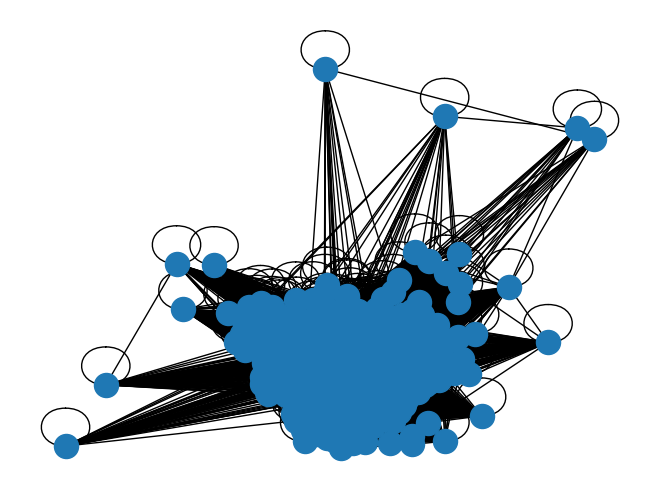

In [19]:
G = nx.from_numpy_array(np.matrix(adjacence))
nx.draw(G)

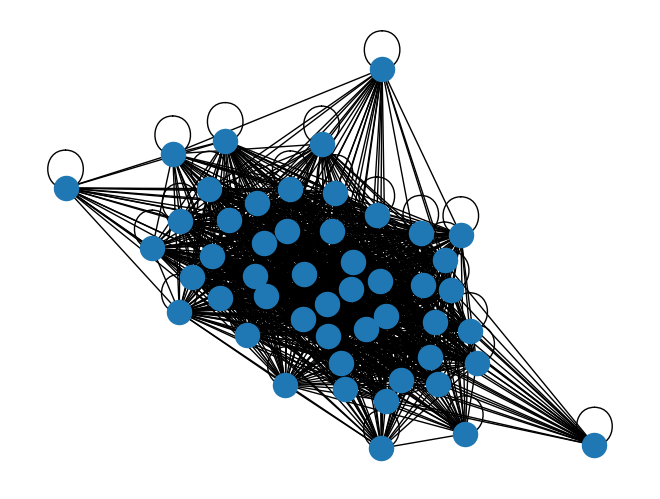

In [34]:
# On prend seulement les premiers 50 noeuds du graphe
G_sub = G.subgraph(list(G.nodes())[:50])

nx.draw(G_sub)

### Mesures de centralité

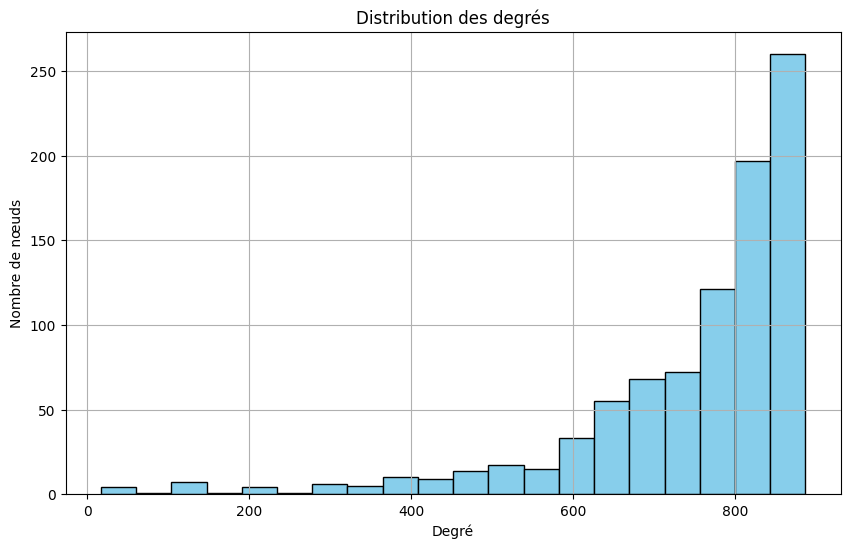

In [20]:
# Distribution des degrés
degree_distribution = [val for (node, val) in G.degree()]

# Plot de la distribution des degrés
plt.figure(figsize=(10, 6))
plt.hist(degree_distribution, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution des degrés')
plt.xlabel('Degré')
plt.ylabel('Nombre de nœuds')
plt.grid(True)
plt.show()

In [21]:
# Calcul de la largeur du graphe
width = nx.diameter(G)

# Calcul de la densité du graphe
density = nx.density(G)

print("Largeur du graphe:", width)
print("Densité du graphe:", density)

Largeur du graphe: 3
Densité du graphe: 0.8328414287479916


In [22]:
# On prend seulement les premiers 50 noeuds du graphe
G_sub = G.subgraph(list(G.nodes())[:50])

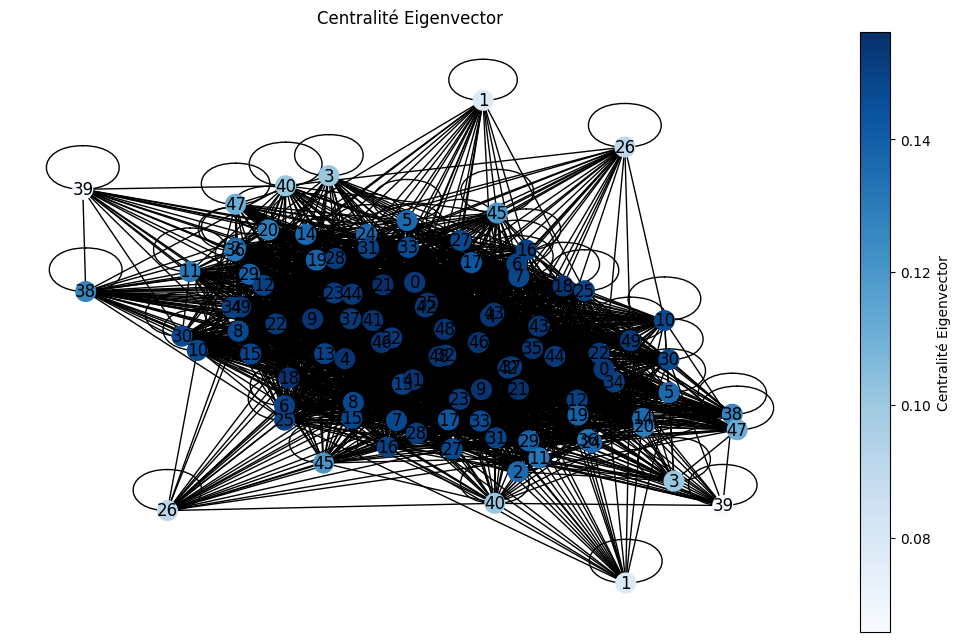

In [23]:
# Calcul de la centralité eigenvector
eigenvector_cent = nx.eigenvector_centrality(G_sub)

# Création de la figure
plt.figure(figsize=(10, 6))

# Dessin du graphe avec coloration basée sur la centralité eigenvector
pos = nx.spring_layout(G_sub)
nx.draw(G_sub, pos, node_color=list(eigenvector_cent.values()), cmap=plt.cm.Blues, node_size=200, with_labels=True)

# Dessin du graphe avec coloration basée sur la centralité eigenvector
pos = nx.spring_layout(G_sub)
nodes = nx.draw_networkx_nodes(G_sub, pos, node_color=list(eigenvector_cent.values()), cmap=plt.cm.Blues, node_size=200)
nx.draw_networkx_edges(G_sub, pos)
nx.draw_networkx_labels(G_sub, pos)
plt.colorbar(nodes, label='Centralité Eigenvector')

# Affichage du titre
plt.title('Centralité Eigenvector')

# Affichage du graphe
plt.show()

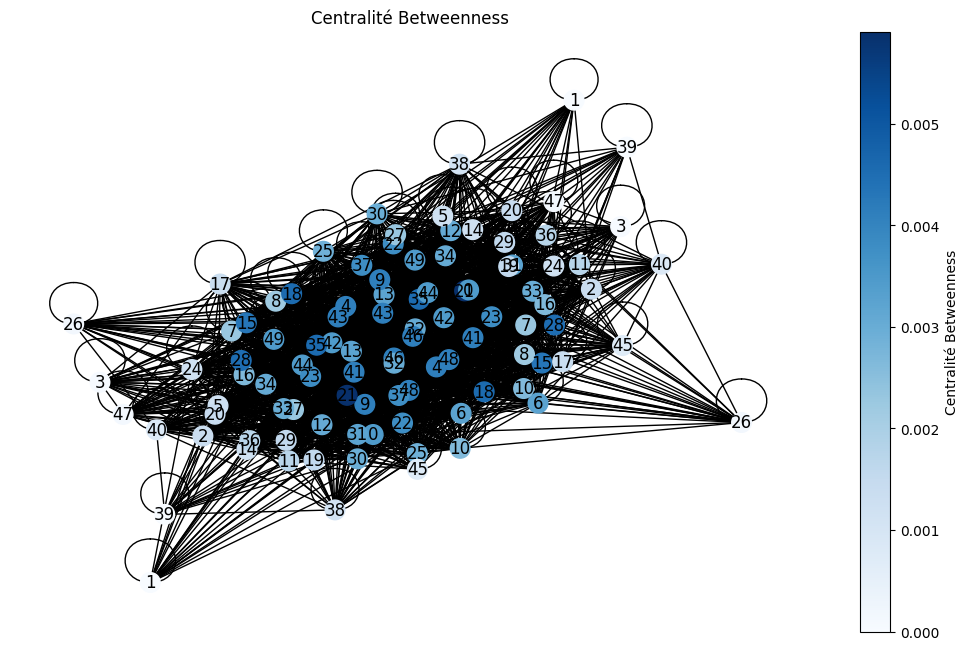

In [24]:
# Calcul de la centralité betweenness
betweenness_cent = nx.betweenness_centrality(G_sub)

# Création de la figure
plt.figure(figsize=(10, 6))

# Dessin du graphe avec coloration basée sur la centralité betweenness
pos = nx.spring_layout(G_sub)
nx.draw(G_sub, pos, node_color=list(betweenness_cent.values()), cmap=plt.cm.Blues, node_size=200, with_labels=True)

# Dessin du graphe avec coloration basée sur la centralité betweenness
pos = nx.spring_layout(G_sub)
nodes = nx.draw_networkx_nodes(G_sub, pos, node_color=list(betweenness_cent.values()), cmap=plt.cm.Blues, node_size=200)
nx.draw_networkx_edges(G_sub, pos)
nx.draw_networkx_labels(G_sub, pos)
plt.colorbar(nodes, label='Centralité Betweenness')

# Affichage du titre
plt.title('Centralité Betweenness')

# Affichage du graphe
plt.show()

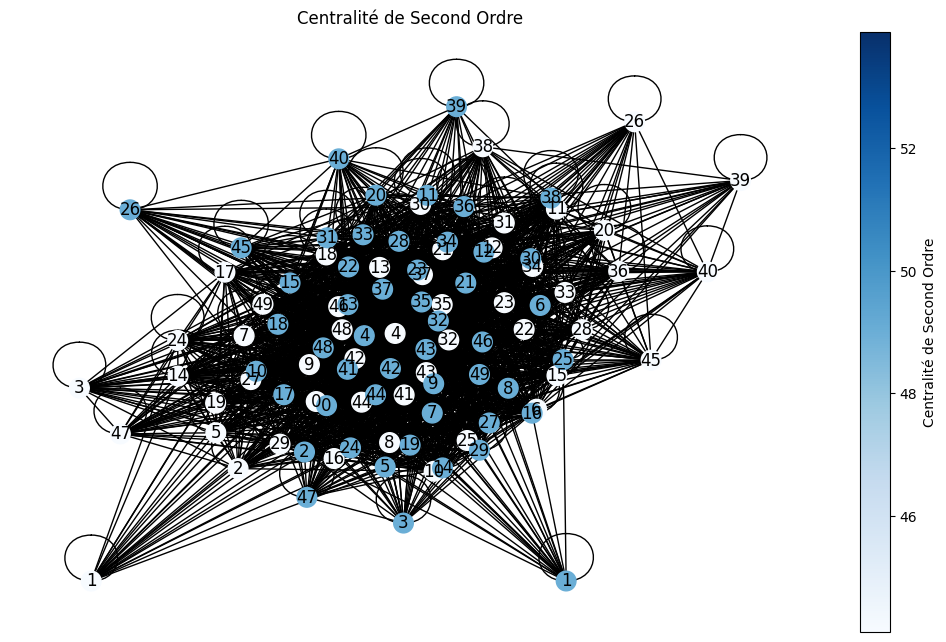

In [25]:
def second_order_centrality(G_sub):
    second_order_cent = {}
    for node in G_sub.nodes():
        neighbors = set(G_sub.neighbors(node))
        second_order_neighbors = set()
        for neighbor in neighbors:
            second_order_neighbors.update(G_sub.neighbors(neighbor))
        second_order_neighbors.remove(node)
        second_order_cent[node] = len(second_order_neighbors)
    return second_order_cent

# Calcul de la centralité de second ordre
second_order_cent = second_order_centrality(G_sub)

# Création de la figure
plt.figure(figsize=(10, 6))

# Dessin du graphe avec coloration basée sur la centralité de second ordre
pos = nx.spring_layout(G_sub)
nx.draw(G_sub, pos, node_color=list(second_order_cent.values()), cmap=plt.cm.Blues, node_size=200, with_labels=True)

# Dessin du graphe avec coloration basée sur la centralité de second ordre
pos = nx.spring_layout(G_sub)
nodes = nx.draw_networkx_nodes(G_sub, pos, node_color=list(second_order_cent.values()), cmap=plt.cm.Blues, node_size=200)
nx.draw_networkx_edges(G_sub, pos)
nx.draw_networkx_labels(G_sub, pos)
plt.colorbar(nodes, label='Centralité de Second Ordre')

# Affichage du titre
plt.title('Centralité de Second Ordre')

# Affichage du graphe
plt.show()

## Fonction 3 - Moteur de recherche

In [26]:
import ipywidgets as widgets
from IPython.display import display
from sklearn.metrics.pairwise import cosine_similarity

def search_articles(query):
    # Calculer l'embedding BERT des mots-clés
    query_embedding = model(tokenizer.encode(query, add_special_tokens=True, return_tensors="pt")).pooler_output

    # Calculer la similarité entre les mots-clés et les séquences d'articles
    similarities = cosine_similarity(query_embedding.detach().numpy(), encoded_sequences.detach().numpy())

    # Récupérer les indices des articles triés par similarité décroissante
    sorted_indices = np.argsort(similarities[0])[::-1]

    # Afficher les mots-clés de la requête
    print("Mots-clés de la recherche:", query)
    print("-------------------------------------------")

    # Afficher les articles les plus pertinents
    num_articles_to_show = 10
    for i in range(num_articles_to_show):
        index = sorted_indices[i]
        print(f"Article {i + 1}:")
        print("Titre:", sequences[index])
        print("Domaine:", y_domaine[index])
        print("Similarité avec la requête:", similarities[0][index])
        print()

# Créer un widget de texte pour saisir les mots-clés
search_box = widgets.Text(placeholder="Entrez les mots-clés")

# Créer une fonction de recherche qui sera appelée lors de la soumission du texte
def on_submit(sender):
    query = search_box.value
    #print("Bienvenue sur notre moteur de recherche")
    print("-------------------------------------------")
    search_articles(query)

# Associer la fonction de recherche à l'événement de soumission du widget de texte
search_box.on_submit(on_submit)

# Afficher le titre de l'interface
print("Bienvenue sur notre moteur de recherche\n")

# Afficher le widget de texte pour le moteur de recherche
display(search_box)

Bienvenue sur notre moteur de recherche



Text(value='', placeholder='Entrez les mots-clés')

## Fonction 4 - Ajout de clustering

### Clustering Spectral

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:248: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


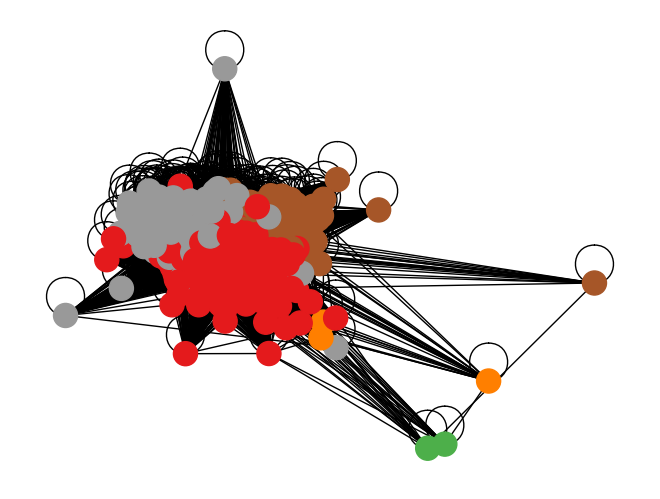

In [27]:
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt

# Effectuer le clustering spectral
n_clusters = 5  # Nombre de clusters à trouver
spectral = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=0)
clusters = spectral.fit_predict(adjacence)

# Afficher le graphe avec les clusters colorés
pos = nx.spring_layout(G)  # Positionnement des nœuds
nx.draw(G, pos, node_color=clusters, cmap=plt.cm.Set1, with_labels=False)
plt.show()

### Clustering de Louvain

In [28]:
#!pip install --upgrade python-louvain
import community.community_louvain as community_louvain

partition = community_louvain.best_partition(G)

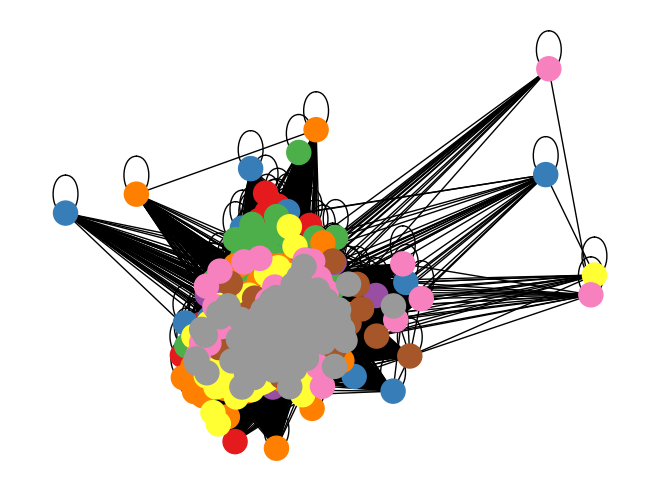

In [29]:
# Algorithme de Louvain pour le clustering
partition = nx.community.label_propagation.label_propagation_communities(G)

# Convertir la partition en un dictionnaire attribuant à chaque nœud son cluster
node_cluster_mapping = {node: cluster_id for cluster_id, nodes in enumerate(partition) for node in nodes}

# Dessin du graphe avec les couleurs représentant les clusters
pos = nx.spring_layout(G)
colors = [node_cluster_mapping[n] for n in G.nodes()]
nx.draw(G, pos, node_color=colors, cmap=plt.cm.Set1, with_labels=False)
plt.show()

## Fonction 5 - Classification supervisée

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(encoded_sequences.numpy(), y_domaine, test_size=0.2, random_state=42)

# Entraîner un classifieur de régression logistique
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
predictions = classifier.predict(X_test)

# Calculer l'accuracy du modèle
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8888888888888888


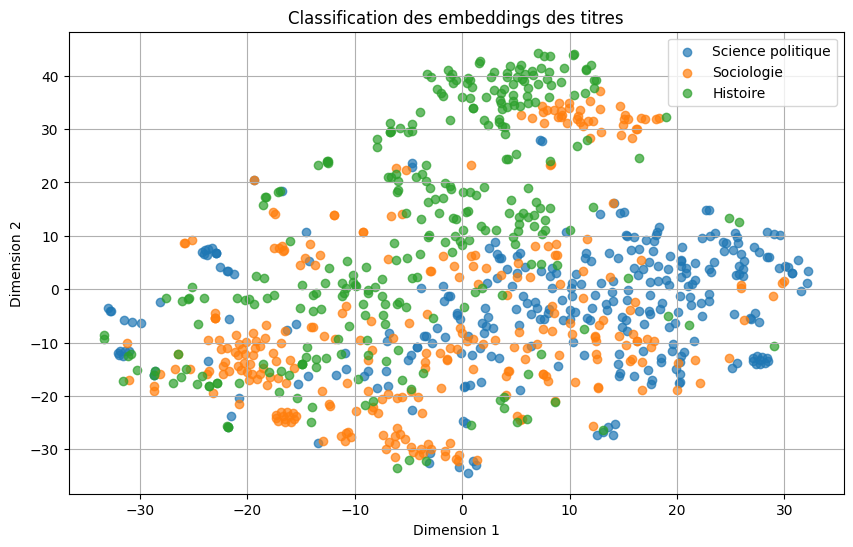

In [40]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Réduire la dimension des embeddings à deux dimensions en utilisant t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(encoded_sequences.numpy())

# Tracer les embeddings en fonction de leur classe prédite
plt.figure(figsize=(10, 6))
for domaine in set(y_domaine):
    indices = [i for i, label in enumerate(y_domaine) if label == domaine]
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=domaine, alpha=0.7)

plt.title('Classification des embeddings des titres')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

#### Données de test

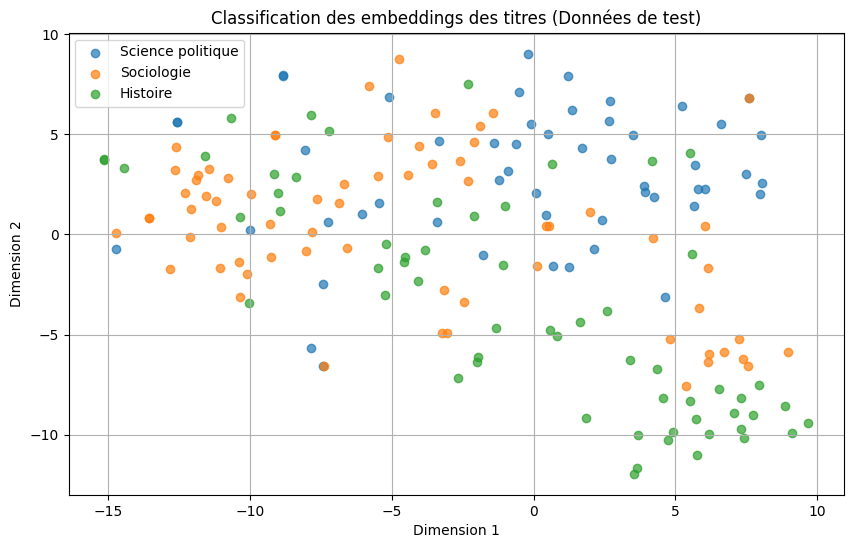

In [43]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Réduire la dimension des embeddings à deux dimensions en utilisant t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(X_test)  # Utiliser uniquement les embeddings de l'ensemble de test

# Tracer les embeddings en fonction de leur classe prédite
plt.figure(figsize=(10, 6))
for domaine in set(y_test):
    indices = [i for i, label in enumerate(y_test) if label == domaine]
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=domaine, alpha=0.7)

plt.title('Classification des embeddings des titres (Données de test)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

#### Données d'entraînement

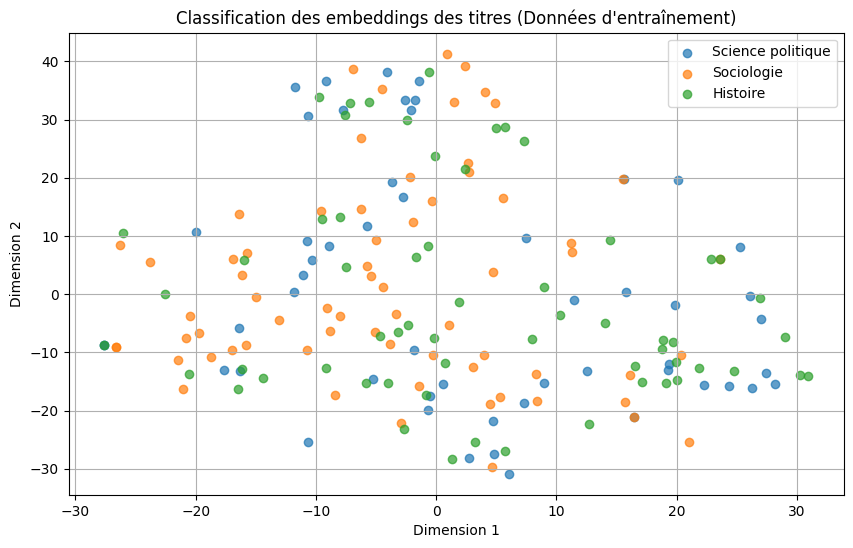

In [44]:
# Réduire la dimension des embeddings à deux dimensions en utilisant t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(X_train)  # Utiliser uniquement les embeddings de l'ensemble d'entrainement

# Tracer les embeddings en fonction de leur classe prédite
plt.figure(figsize=(10, 6))
for domaine in set(y_test):
    indices = [i for i, label in enumerate(y_test) if label == domaine]
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=domaine, alpha=0.7)

plt.title('Classification des embeddings des titres (Données d\'entraînement)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.grid(True)
plt.show()
